## Anzahl relevanter Artikel ermitteln und in Balkendiagrammen plotten

Speicherort festlegen und "sources" als Liste definieren

In [2]:
import json

data_dir = "../data/"

sources = ["faz/",  "sz/",  "zeit/",  "spiegel/"]


Articles als Liste definiert und ein json-file mit allen articles in passenden Ordnern abgelegt

In [3]:
articles = []

for source in sources:
    with open(data_dir + source + "all-articles.json") as file: 
        tmp = json.load(file)
        articles += tmp

Insgesamt gibt es 6310 Artikel, die in Titel, Übertitel oder Abstract "Jemen" enthalten

In [4]:
len(articles)

6310

Liste relevanter Artikel erstellt und ihr jene angehängt, die Jemen im Titel oder Surtitle haben sowie ihre Anzahl bestimmt

In [5]:
relevant_articles = []

for article in articles:
    if "jemen" in article["title"].lower() or "jemen" in article["surtitle"].lower():
        relevant_articles.append(article)

len(relevant_articles)


938

2 Dataframes (zweidimensionale Datenstruktur, Tabelle/Spreadsheet) erstellt

In [6]:
import pandas as pd

rel = pd.DataFrame(relevant_articles)
all = pd.DataFrame(articles)


??Wie viele relevante Artikel gibt es pro source 

In [7]:
rel["source"].value_counts()


FAZ        377
SZ         306
Spiegel    137
Zeit       118
Name: source, dtype: int64

Wie viele Artikel gibt es pro source 

In [8]:
all["source"].value_counts()

FAZ        2411
SZ         1938
Spiegel    1343
Zeit        618
Name: source, dtype: int64

So viele Artikel haben Autoren (oder: the dirty way to find out wie viele FAZ Artikel Autoren haben)
- Liste aller Artikel mit Autoren erstellen
- Menge ausgeben lassen
- Dataframe erstellen

In [15]:
author_articles = []

for article in relevant_articles:
    if article["author"].lower() != "":
        author_articles.append(article)

print(len(author_articles))

aut = pd.DataFrame(author_articles)

49


Dataframe aller rel. Art. ohne Spiegel
Alle strings der Kategorie "date" und des Formats "%d.%m.%Y" in diesem Dataframe in datetimes umwandeln

In [10]:
rel_sp = rel[rel["source"] != "Spiegel"]

rel_sp["date"] = pd.to_datetime(rel_sp["date"], format="%d.%m.%Y")


C:\Users\ddoro\AppData\Local\Temp\ipykernel_30960\2939919707.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rel_sp["date"] = pd.to_datetime(rel_sp["date"], format="%d.%m.%Y")


## Plotting

Plottet alle relevanten Artikel ohne Spiegel anhand ihres Datums und groupiert in Jahre

<AxesSubplot:xlabel='date'>

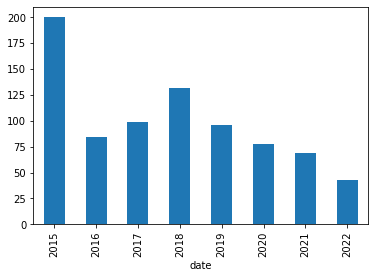

In [11]:
rel_sp['date'].groupby(rel_sp['date'].dt.year).count().plot(kind="bar")

In [12]:
year_info = {1: ("January", 31), 2: ("February", 28), 3: ("March", 31), 4: ("April", 30), 5: ("May", 31), 6: ("June", 30), 7: ("July", 31), 8: ("August", 31), 9: ("September", 30), 10: ("October", 31), 11: ("November", 30), 12: ("December", 31)}

Speichert die Dataframes in einem Dictionary namens "articlesByYear", wobei der key dem Jahr entspricht und der value dem dataframe

In [13]:
articlesByYear = {}

def generateArticlesByMonth(articles, year):
    articlesByMonth = {}
    for month in year_info.keys():
        articlesForThisMonth = articles[articles['date'].dt.month == month]
        counts = articlesForThisMonth['date'].groupby(articles['date'].dt.day).count()
        for day in range(1,year_info[month][1] + 1):
            if day not in counts:
                counts.at[day] = 0
        if year in [2020,2016] and 29 not in counts: 
            counts.at[29] = 0
        counts.sort_index(inplace=True)
        articlesByMonth[month] = counts
    return (articlesByMonth)


for year in range(2015,2023): 
    articlesForThisYear = rel_sp[rel_sp['date'].dt.year == year]
    # counts ist eine series (sozusagen eine Spalte von einem Dataframe)
    counts = articlesForThisYear['date'].groupby(rel_sp['date'].dt.month).count()
    # wenn für einen monat kein eintrag vorhanden ist, wird auch kein eintrag in counts erzeugt
    # deshalb iterieren wir über alle monate (1-12) und wenn der Monat nicht in counts ist, 
    # fügen wir einen Eintrag mit dem Wert 0 hinzu
    for month in range(1,13):
        if month not in counts:
            counts.at[month] = 0
    # da wir die 0-einträge immer unten angehängt haben, sortieren wir das dataframe (default aufsteigend)
    counts.sort_index(inplace=True)
    articlesByMonth = generateArticlesByMonth(articlesForThisYear, year)
    articlesByYear[year] = [articlesForThisYear, counts, articlesByMonth]


filter data frame rows to only those rows for which the expression in the brackets evaluates to true

In [14]:
len(articlesByYear[2021][articlesByYear[2021]["date"].dt.month == 1])

TypeError: list indices must be integers or slices, not str

Definition für das Plotten der Balkendiagramme mit dem Titel des jeweiligen Jahres, der x-Achse Monate, der y-Achse Artikel und dem Dateinamen Jahr und dem Format jpg
Dann: clearen, damit die counts nicht einfach hinzugefügt werden

In [ ]:
def plot_counts(counts, year):
    plot = counts.plot(kind="bar")
    plot.set_title(year)
    plot.set_xlabel("Monat")
    plot.set_ylabel("Artikel")
    plot.figure.savefig(str(year)+".jpg")
    plot.figure.clear()

In [ ]:
# for key, value in dictionary.items()
for year, value in articlesByYear.items():

        # unser dataframe mit den anzahlen der artikel und dem zugehörigen jahr wird zum plotten der Funktion übergeben
        plot_counts(value[1], year)

<Figure size 432x288 with 0 Axes>

Dictionary namens "year_info" dazu, wie viele Tage welcher Monat haben kann

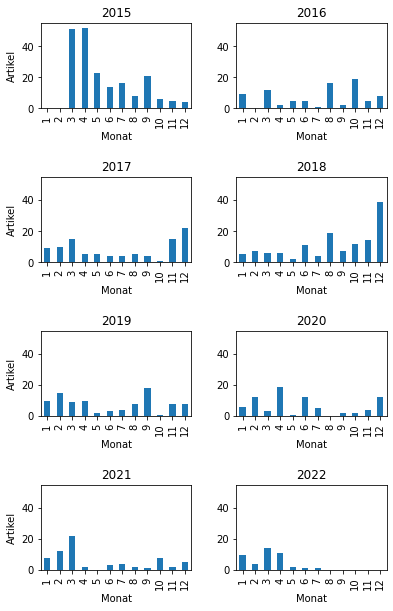

In [ ]:
import matplotlib.pyplot as plt

rows = 4
cols = 2

fig, axes = plt.subplots(nrows = rows, ncols = cols)

yearIndex = 0
for row in range(rows):
    for col in range(cols):
        year = list(articlesByYear.keys())[yearIndex]
        articlesByYear[year][1].plot(kind = "bar", ax = axes[row, col]).set_title(str(year))
        axes[row, col].set_ylim([0, 55])
        axes[row, col].set_xlabel("Monat")
        if col == 0:
            axes[row, col].set_ylabel("Artikel")
        yearIndex += 1

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=2, 
                    wspace=0.3, 
                    hspace=0.8)

plt.savefig("yearsOverview.jpg", bbox_inches="tight")

In [ ]:
for year in range(2015,2023):
    articlesByMonth = articlesByYear[year][2]

    rows = 4
    cols = 3

    fig, axes = plt.subplots(nrows = rows, ncols = cols)
    fig.set_size_inches(18.5, 3.5)
    fig.suptitle(str(year), fontsize=18, y=2.2)

    monthIndex = 0

    for row in range(rows):
        for col in range(cols):
            month = list(articlesByMonth.keys())[monthIndex]
            articlesByMonth[month].plot(kind = "bar", ax = axes[row, col]).set_title(year_info[month][0])
            axes[row, col].set_ylim([0, 16])
            axes[row, col].set_xlabel("Tag")
            if col == 0:
                axes[row, col].set_ylabel("Artikel")
            monthIndex += 1

    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=2, 
                        wspace=0.3, 
                        hspace=0.8)

    plt.savefig("plots/" + str(year) + "/byMonth.jpg", bbox_inches="tight")



In [ ]:
len(rel_sp[rel_sp["author"] == "Christoph Ehrhardt"])

22

In [ ]:
len(rel_sp[rel_sp["surtitle"] != ""])

726

In [ ]:
len(rel_sp)

801